# 1. Import Libraries

In [3]:
# Standard lbrary imports
from IPython.display import clear_output, display, HTML
import pandas as pd
import numpy as np
from pathlib import Path
import random
from dateutil.relativedelta import relativedelta
from IPython.display import display
from pyarrow import feather

# Visualization libraries
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact
import anywidget

# Sklearn imports
from sklearn.metrics import roc_curve, auc, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, precision_recall_curve, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.stats import kurtosis, skew, zscore, randint, uniform
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import clone  # <-- add this import at the top of the module

# Miscelaneous
from tqdm import tqdm
from colorama import Fore, Back, Style
import warnings
import importlib
import logging
from typing import List, Dict, Tuple, Union, Optional
import time
import sys
import pickle
import joblib
import json
from datetime import datetime 

#Configuration and setting
random.seed(42)
warnings.filterwarnings('ignore')
# set_config(transform_output="pandas")
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)

from __future__ import annotations
from collections import namedtuple
from typing import Literal, Optional

%load_ext autoreload
%autoreload 2

# utility function

IMAGES_PATH = Path() / "images" / "classfication"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_id, tight_layout=True, file_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
import src.functions
import src.preprocess
import src.inference

importlib.reload(src.functions)
importlib.reload(src.preprocess)
importlib.reload(src.inference)

<module 'src.inference' from '/home/coder/workspace/direct_review/src/inference.py'>

# 2. Read Data

In [5]:
from sparrow_objs import fs

BUCKET_NAME = "direct-ob-2792"

with fs.open(f"{BUCKET_NAME}/data/demanda_direct_out.sas7bdat", "rb") as fd:
    data = pd.read_sas(fd, format='sas7bdat',  encoding='utf8')

data.columns = data.columns.str.lower().str.replace(' ', '_')

#Standarize names
strings = list(data.dtypes[data.dtypes == 'object'].index)
for col in strings:
    data[col] = data[col].str.lower().str.replace(' ', '_')

for col in data.select_dtypes("category").columns:
    data[col] = data[col].astype(str)
    
    data[col] = data[col].astype("category")

print(f"Data set size:{data.shape[0]} samples, {data.shape[1]} features")
print("First 5 rows")
data.head(5)
print("\nDataset Info:")
data.info()

Data set size:1017641 samples, 35 features
First 5 rows

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017641 entries, 0 to 1017640
Data columns (total 35 columns):
 #   Column                         Non-Null Count    Dtype        
---  ------                         --------------    -----        
 0   segment_cutoff_1               1017622 non-null  object       
 1   segment_cutoff_2               1014089 non-null  object       
 2   segment_cutoff_3               402886 non-null   object       
 3   segment_cut_off                1017641 non-null  object       
 4   mis_date                       1017641 non-null  datetime64[s]
 5   status_name                    1017641 non-null  object       
 6   account_id                     66032 non-null    float64      
 7   authorization_id               1017641 non-null  float64      
 8   product_type_1                 1017641 non-null  object       
 9   product_type_2                 1017641 non-null  object       


In [6]:
data.segment_cut_off.value_counts()

segment_cut_off
personal_loans,_fusion_and_tj_direct-no_ob/no_fintonic-                          420302
personal_loans,_fusion_and_tj_direct-no_premium-c-d                               92233
personal_loans,_fusion_and_tj_direct-no_premium-e-f                               86681
personal_loans,_fusion_and_tj_direct-no_premium->=g                               84387
personal_loans,_fusion_and_tj_direct-openbanking-                                 60077
personal_loans,_fusion_and_tj_direct-no_premium-a-b                               58259
consolidation-balconin-new/inactive-                                              52934
personal_loans,_fusion_and_tj_direct-premium-                                     43385
consolidation-balconin-no_premium-a-f                                             41129
personal_loans,_fusion_and_tj_direct-precon_gold_and_silver-new/inactive,_a-e     30401
personal_loans,_fusion_and_tj_direct-fintonic-                                    17837
consolidation-ba

# Preprocessing

In [7]:
cz2021, cz2022, cz2023, cz2024, cz2025 = 1.1, 1.1, 1.1, 1.1, 1.3

date_ini_book_obs = pd.to_datetime('2024-05-01')
date_fin_book_obs = pd.to_datetime('2025-04-01')

n_month = (
    (date_fin_book_obs.year  - date_ini_book_obs.year)  * 12 +
    (date_fin_book_obs.month - date_ini_book_obs.month) + 1
)

annual_coef = 12/n_month

print(f"Start date : {date_ini_book_obs.date()}")
print(f"End date   : {date_fin_book_obs.date()}")
print(f"n_month    : {n_month}")
print(f"annual_coef: {annual_coef:.4f}")


keep_vars  = ['mis_date', 'status_name', 'risk_score_rf','se_decision_id','fuera_norma','reject_reason','score_rf','segment_cut_off','early_bad']

indicators = ['acct_booked_h0','oa_amt','todu_30ever_h6','todu_amt_pile_h6','oa_amt_h0']

variables  = ['sc_octroi_new_clus','new_efx_clus']

octroi_new_bins = [-np.inf, 364, 370, 379, 382, 389, 397, 404, 416, 431, np.inf]
efx_new_bins = [-np.inf,2,7,11,16,22,27,33,38,43,47,51,56,62,68,73,78,83,89,94, np.inf]

score_measures = [
                  'm_ct_direct_sc_nov23', 'm_ct_direct_sc_jan23', 'm_ct_direct_sc_conso25' , 'm_ct_direct_sc_precon25', 
                  'm_ct_direct_sc_fintonic25' , 'm_ct_direct_sc_direct25_total'
                 ]

segment_filter =  ['personal_loans,_fusion_and_tj_direct-premium-']

#segment_filter =  ['personal_loans,_fusion_and_tj_direct-premium-','personal_loans,_fusion_and_tj_direct-precon_gold_and_silver-new/inactive,_a-e']

var_target = 'b2_ever_h6'

# Run the preprocessing pipeline with logging
data_clean, data_booked, data_demand = src.preprocess.complete_preprocessing_pipeline(
    data,
    keep_vars,
    indicators,
    segment_filter,
    octroi_new_bins,
    efx_new_bins,
    variables,
    date_ini_book_obs,
    date_fin_book_obs,
    score_measures,
    log_level=logging.INFO,
    log_file="preprocessing.log"
)

Start date : 2024-05-01
End date   : 2025-04-01
n_month    : 12
annual_coef: 1.0000
2026-01-22 12:25:58,632 - preprocessing - INFO - ===== Starting complete preprocessing pipeline =====
2026-01-22 12:25:58,633 - preprocessing - INFO - Input data shape: (1017641, 35)
[2026-01-22T12:25:58.632][sop-877552-reg-jl--d58cb329-f9f5cddd7-mzsvj][coder][2263][127365182151552][/home/coder/workspace/direct_review/src/preprocess.py:416][preprocessing][INFO]
===== Starting complete preprocessing pipeline =====
2026-01-22 12:25:58,634 - preprocessing - INFO - Observation period: 2024-05-01 00:00:00 to 2025-04-01 00:00:00
[2026-01-22T12:25:58.633][sop-877552-reg-jl--d58cb329-f9f5cddd7-mzsvj][coder][2263][127365182151552][/home/coder/workspace/direct_review/src/preprocess.py:417][preprocessing][INFO]
Input data shape: (1017641, 35)
2026-01-22 12:25:58,636 - preprocessing - INFO - Step 1: Basic filtering
[2026-01-22T12:25:58.634][sop-877552-reg-jl--d58cb329-f9f5cddd7-mzsvj][coder][2263][127365182151552][

### Con Medidas

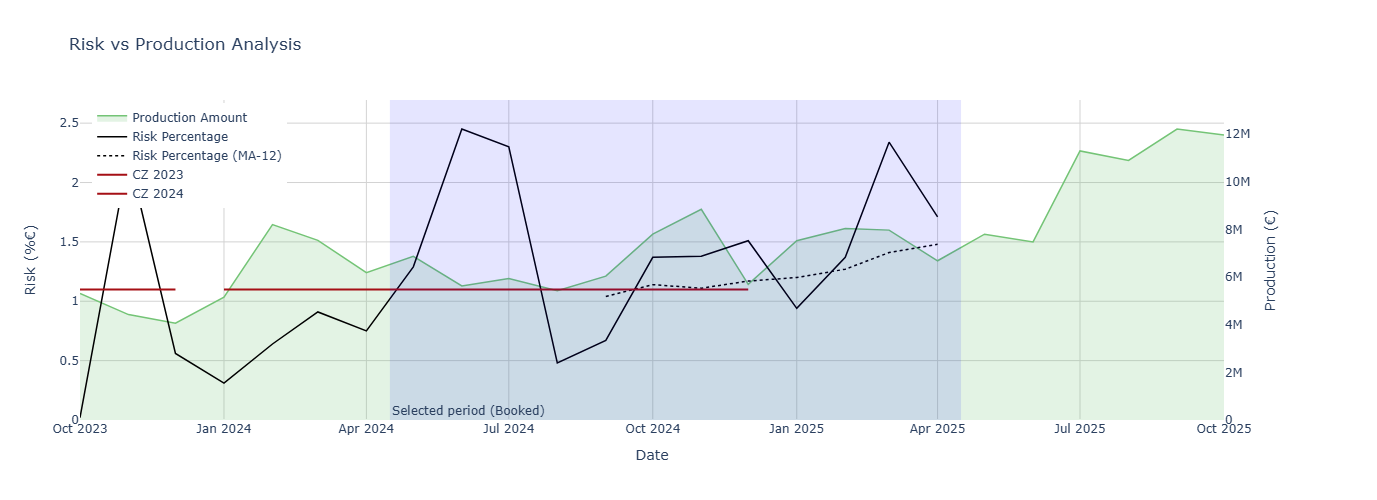

In [6]:
src.functions.plot_risk_vs_production(data_clean, indicators, cz2022,
                        cz2023, cz2024, data_booked, 12)

# Stress Factor

In [7]:
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from collections import namedtuple

StressResult = namedtuple(
    "StressResult",
    [
        "status",                # status that was filtered (e.g. 'booked')
        "bad_rate",              # observed proportion of bads
        "n_obs",                 # number of observations used
        "ci_lower", "ci_upper",  # chosen confidence‑interval
        "stressed_rate",         # upper bound / observed rate
        "method",                # CI method used
    ],
)


def stress_factor(
    df: pd.DataFrame,
    status_col: str = "status_name",
    target_status: str = "booked",
    bad_col: str = "early_bad",
    conf: float = 0.99,
    ci_method: str = "wilson",
) -> StressResult:
    """
    Compute a stress factor for a binary outcome (bad / good) inside a
    particular status slice of a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Source data.
    status_col : str, default "status_name"
        Column that holds the status (e.g. *booked*, *rejected*).
    target_status : str, default "booked"
        Value of ``status_col`` that will be analysed.
    bad_col : str, default "early_bad"
        Binary column (1 = bad, 0 = good).  Missing values are ignored.
    conf : float, default 0.99
        Desired confidence level for the upper bound.
    ci_method : str, default "wilson"
        Confidence‑interval method.  Options are the methods accepted by
        ``statsmodels.stats.proportion.proportion_confint``:
        ``'wilson'``, ``'score'``, ``'beta'`` (Clopper‑Pearson), ``'agresti_coull'``,
        ``'normal'`` (the classic z‑interval you used).

    Returns
    -------
    StressResult
        Named‑tuple containing the observed bad‑rate, its CI, and the stress factor.
    """
    # ------------------------------------------------------------------
    # Filter & clean
    # ------------------------------------------------------------------
    mask = df[status_col] == target_status
    sub = df.loc[mask, bad_col].dropna()          # drop missing outcomes only
    n = sub.shape[0]

    if n == 0:
        raise ValueError(f"No rows found for status = '{target_status}'")

    # ------------------------------------------------------------------
    # Observed proportion
    # ------------------------------------------------------------------
    bad_rate = sub.mean()                         # = successes / n

    # ------------------------------------------------------------------
    # Confidence interval for a binomial proportion
    # ------------------------------------------------------------------
    #   statsmodels returns (lower, upper) in the same order as we need.
    ci_low, ci_up = proportion_confint(
        count=int(sub.sum()),
        nobs=n,
        alpha=1 - conf,
        method=ci_method,
    )

    # ------------------------------------------------------------------
    # Stress factor (upper bound expressed as a multiple of the mean)
    # ------------------------------------------------------------------
    # Guard against division by zero – when bad_rate = 0 the stress factor
    # would be infinite, so we set it to a large sentinel value.
    if bad_rate == 0:
        stressed_rate = np.inf
    else:
        stressed_rate = ci_up / bad_rate

    # ------------------------------------------------------------------
    # Pack results
    # ------------------------------------------------------------------
    return StressResult(
        status=target_status,
        bad_rate=bad_rate,
        n_obs=n,
        ci_lower=ci_low,
        ci_upper=ci_up,
        stressed_rate=stressed_rate,
        method=ci_method,
    )

In [8]:
result = stress_factor(
    df=data_clean,
    status_col="status_name",
    target_status="booked",
    bad_col="early_bad",
    conf=0.99,               # 99 % confidence level
    ci_method="wilson",      # <-- more accurate than normal approx.
)

print(f"Observed Bad Rate (booked): {result.bad_rate:.4%}")
print(f"99 % Wilson CI: [{result.ci_lower:.4%}, {result.ci_upper:.4%}]")
print(f"Stress factor: {result.stressed_rate:.3f}")
print(f"CI method used: {result.method}")

Observed Bad Rate (booked): 0.7367%
99 % Wilson CI: [0.5858%, 0.9261%]
Stress factor: 1.257
CI method used: wilson


In [9]:
stressor = result.stressed_rate 

## Calculo Tasas Financiación

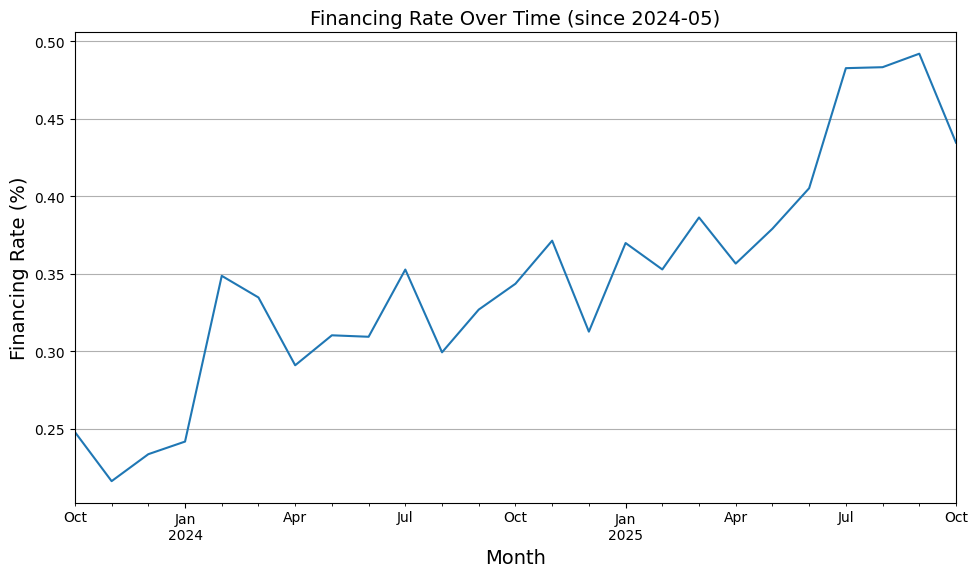


Financing Rate (Mean of last 24 months): 35.2%
Financing Rate (Weighted for last 24 months): 38.1%

--------------------------------
Selected Financing Rate: 35.2%


In [10]:
tasa_fin = src.functions.calculate_financing_rates(data_clean, date_ini_book_obs,24)

In [11]:
print(tasa_fin)

0.35200000000000004


# Load saved models

In [12]:
delq_model = 'model_20251120_135609'
reg_model = 'reg_models/todu_h6_pl_k_p.bin'

In [13]:
final_model, metadata, final_features = src.inference.load_model_for_prediction(f'saved_models/{delq_model}')

✅ Model loaded successfully
   Type: LinearRegression
   Features: 4
   Test R²: 0.1313


In [14]:
with open(reg_model, 'rb') as f_in:
    reg_todu_amt_pile = pickle.load(f_in)

## Aplicar modelo de Optimización

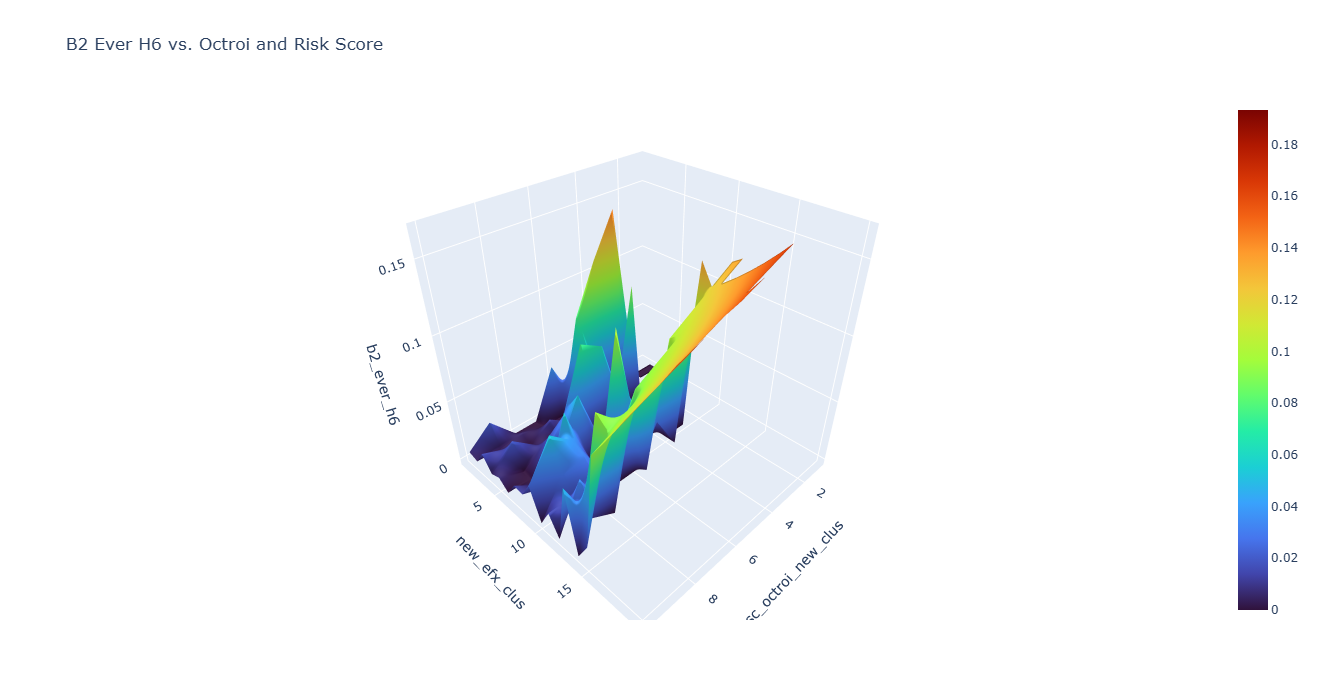

In [15]:
# Define Constants
INDICADORES = indicators
VARIABLES = variables
INDICADORES_BOO = [f"{i}_boo" for i in INDICADORES]
INDICADORES_REP = [f"{i}_rep" for i in INDICADORES]

# Apply Optimization Model
# Calculate aggregate data for booked and repesca cases
def calculate_aggregate_data(data, status, reject_reason=None):
    filtered_data = data[data['status_name'] == status]
    if reject_reason:
        filtered_data = filtered_data[filtered_data['reject_reason'] == reject_reason]
    return (
        filtered_data.groupby(VARIABLES)
        .agg({col: "sum" for col in INDICADORES})
        .mul(annual_coef)  # Multiply by annual coefficient
        .reset_index()[VARIABLES + INDICADORES]
    )

data_sumary_desagregado_booked = calculate_aggregate_data(data_booked, "booked")
data_sumary_desagregado_booked.rename(columns={i: i+'_boo' for i in INDICADORES}, inplace=True)
data_sumary_desagregado_repesca = calculate_aggregate_data(data_demand, "rejected", "09-score")
data_sumary_desagregado_repesca = src.functions.calculate_risk_values(
    data_sumary_desagregado_repesca, final_model, reg_todu_amt_pile, VARIABLES, stressor, final_features
)[VARIABLES + INDICADORES]

data_sumary_desagregado_repesca[INDICADORES] *= tasa_fin
data_sumary_desagregado_repesca.rename(columns={i: i + '_rep' for i in INDICADORES}, inplace=True)

# Merge and adjust indicators
data_sumary_desagregado = data_sumary_desagregado_booked.merge(
    data_sumary_desagregado_repesca, on=VARIABLES, how='outer'
).fillna(0)

for indicador in INDICADORES:
    data_sumary_desagregado[indicador] = (
        data_sumary_desagregado[indicador + '_boo'] +
        data_sumary_desagregado[indicador + '_rep']
    )

# Graph
fig = go.Figure()
data_surf = data_sumary_desagregado.copy()
data_surf['b2_ever_h6'] = 7 * data_surf['todu_30ever_h6'] / data_surf['todu_amt_pile_h6']
data_surf_pivot = data_surf.pivot(index=VARIABLES[1], columns=VARIABLES[0], values='b2_ever_h6')
fig = fig.add_trace(go.Surface(
    x=data_surf_pivot.columns, y=data_surf_pivot.index, z=data_surf_pivot.values, colorscale='turbo'
))
fig.update_layout(
    width=1500,
    height=700,
    scene=dict(
        xaxis=dict(title=VARIABLES[0]),
        yaxis=dict(title=VARIABLES[1]),
        zaxis=dict(title=var_target),
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title="B2 Ever H6 vs. Octroi and Risk Score"  # Add a meaningful title
)
fig.show()

## Optimización

In [16]:
values_var0 = sorted(data_sumary_desagregado[variables[0]].unique())
values_var1 = sorted(data_sumary_desagregado[variables[1]].unique())

In [17]:
# Obtener soluciones factibles
df_v = src.functions.get_fact_sol(
    values_var0=values_var0,
    values_var1=values_var1,
    chunk_size=10000
)

# Obtener KPIs de las soluciones factibles
data_sumary = src.functions.kpi_of_fact_sol(
    df_v=df_v,
    values_var0=values_var0,
    data_sumary_desagregado=data_sumary_desagregado,
    variables=variables,
    indicadores=indicators,
    chunk_size=100000  # Adjust based on available memory
)
# display(data_sumary.head(10))
data_sumary_sample_no_opt = data_sumary.sample(10000)

# Eliminar cortes no óptimos
data_sumary = src.functions.get_optimal_solutions(
    df_v=df_v,
    data_sumary=data_sumary,
    chunk_size=100000  # Adjust based on available memory
)
# display(data_sumary.head(10))

--Getting feasible solutions


Processing Bins: 2it [00:00,  5.23it/s]

Bins: 1/10
Number of feasible solutions: 21
Bins: 2/10
Number of feasible solutions: 231


Processing Bins: 4it [00:00,  5.70it/s]

Bins: 3/10
Number of feasible solutions: 1,771
Bins: 4/10
Number of feasible solutions: 10,626


Processing Bins: 6it [00:01,  5.55it/s]

Bins: 5/10
Number of feasible solutions: 53,130
Bins: 6/10
Number of feasible solutions: 230,230


Processing Bins: 7it [00:01,  4.34it/s]

Bins: 7/10
Number of feasible solutions: 888,030


Processing Bins: 8it [00:02,  1.91it/s]

Bins: 8/10
Number of feasible solutions: 3,108,105


Processing Bins: 9it [00:06,  1.71s/it]

Bins: 9/10
Number of feasible solutions: 10,015,005


Processing Bins: 10it [00:21,  2.14s/it]

Bins: 10/10
Number of feasible solutions: 30,045,015


--Calculating KPIs for feasible solutions


Processing chunks: 100%|██████████| 301/301 [03:57<00:00,  1.27it/s]


--Getting optimal solutions


Processing chunks: 100%|██████████| 301/301 [00:51<00:00,  5.81it/s]


Number of optimal solutions: 91


In [18]:
data_sumary_desagregado['b2_ever_h6'] = np.round(
    100*7*data_sumary_desagregado['todu_30ever_h6']/data_sumary_desagregado['todu_amt_pile_h6'], 2)
data_sumary_desagregado['text'] = data_sumary_desagregado.apply(lambda x: str(
    "{:,.2f}M".format(x['oa_amt_h0']/1000000))+' '+str("{:.2%}".format(x['b2_ever_h6']/100)), axis=1)

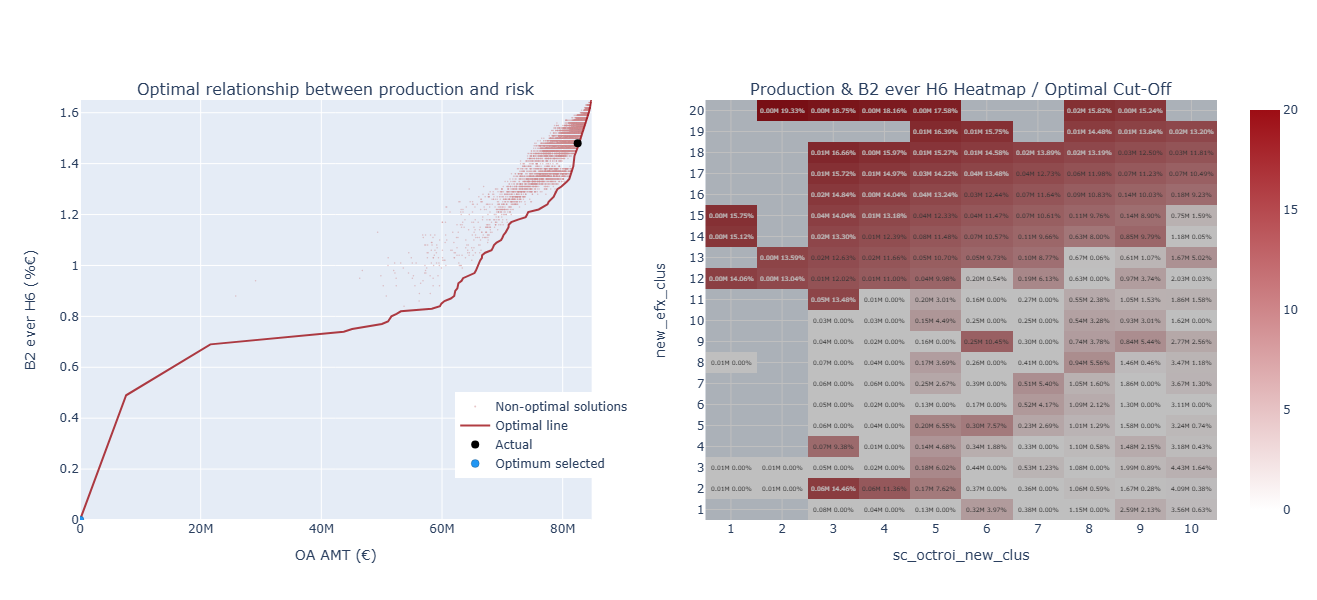

interactive(children=(FloatSlider(value=1.1, continuous_update=False, description='Risk level', layout=Layout(…

In [19]:
visualizer = src.functions.RiskProductionVisualizer(
     data_summary=data_sumary,
     data_summary_disaggregated=data_sumary_desagregado,
     data_summary_sample_no_opt=data_sumary_sample_no_opt,
     variables=variables,
     values_var0=values_var0,
     values_var1=values_var1,
     cz2024=cz2024,
     tasa_fin=tasa_fin
)

visualizer.display()

In [20]:
data_sumary.head()

,sol_fac,1,2,3,4,5,6,7,8,9,10,index,new_efx_clus,acct_booked_h0_boo,oa_amt_boo,todu_30ever_h6_boo,todu_amt_pile_h6_boo,oa_amt_h0_boo,acct_booked_h0_rep,oa_amt_rep,todu_30ever_h6_rep,todu_amt_pile_h6_rep,oa_amt_h0_rep,acct_booked_h0,oa_amt,todu_30ever_h6,todu_amt_pile_h6,oa_amt_h0,acct_booked_h0_cut,oa_amt_cut,todu_30ever_h6_cut,todu_amt_pile_h6_cut,oa_amt_h0_cut,b2_ever_h6,b2_ever_h6_cut,b2_ever_h6_rep,b2_ever_h6_boo
0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,7800.0,83637896.0,1.108550e+06,522826784.0,82482376.0,0.00,1.48,0.0,0.00
1,2,0,0,0,0,0,0,0,0,0,2,2,3.0,620.0,7748775.0,33674.421875,47805028.0,7646775.0,0.0,0.0,0.0,0.0,0.0,620.0,7748775.0,33674.421875,47805028.0,7646775.0,7180.0,75889128.0,1.074876e+06,475021760.0,74835600.0,0.49,1.58,0.0,0.49
2,6,0,0,0,0,0,0,0,0,0,6,6,21.0,1750.0,21927396.0,134343.015625,136298928.0,21608934.0,0.0,0.0,0.0,0.0,0.0,1750.0,21927396.0,134343.015625,136298928.0,21608934.0,6050.0,61710504.0,9.742072e+05,386527872.0,60873436.0,0.69,1.76,0.0,0.69
5,10032348,1,1,1,1,1,3,4,4,6,6,10032348,71.0,3629.0,40170392.0,264617.750000,252253728.0,39581432.0,0.0,0.0,0.0,0.0,0.0,3629.0,40170392.0,264617.750000,252253728.0,39581432.0,4171.0,43467508.0,8.439325e+05,270573056.0,42900940.0,0.73,2.18,0.0,0.73
4,5829,0,0,0,0,0,0,4,4,7,7,5829,76.0,3888.0,44318864.0,295076.687500,277846752.0,43716900.0,0.0,0.0,0.0,0.0,0.0,3888.0,44318864.0,295076.687500,277846752.0,43716900.0,3912.0,39319036.0,8.134736e+05,244980032.0,38765472.0,0.74,2.32,0.0,0.74


In [21]:
pl_kn_p = data_sumary[(data_sumary[1] == 7) & (data_sumary[2] == 7) & (data_sumary[3] == 7) & (data_sumary[4] == 7) & (data_sumary[5] == 7) & (data_sumary[6] == 8) & (data_sumary[7] == 11) & (data_sumary[8] == 13) & (data_sumary[9] == 13) & (data_sumary[10] == 15)].T

In [23]:
pl_kn_p.to_excel('pl_kn_p.xlsx')